<a href="https://colab.research.google.com/github/ritiksharma4/glaucomaDetectionCNN/blob/main/glaucomaCNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
mkdir ~/.kaggle

In [2]:
cp kaggle.json ~/.kaggle/

In [ ]:
!cp kaggle.json ~/.kaggle/
!kaggle datasets download -d andrewmvd/ocular-disease-recognition-odir5k
!unzip ocular-disease-recognition-odir5k.zip
!mkdir ODIR-5K/Validation_Images

In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import cv2
import random
from tqdm import tqdm
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/content/ODIR-5K'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

In [6]:
df = pd.read_csv("/content/full_df.csv")
df.head(3)

,ID,Patient Age,Patient Sex,Left-Fundus,Right-Fundus,Left-Diagnostic Keywords,Right-Diagnostic Keywords,N,D,G,C,A,H,M,O,filepath,labels,target,filename
0,0,69,Female,0_left.jpg,0_right.jpg,cataract,normal fundus,0,0,0,1,0,0,0,0,../input/ocular-disease-recognition-odir5k/ODI...,['N'],"[1, 0, 0, 0, 0, 0, 0, 0]",0_right.jpg
1,1,57,Male,1_left.jpg,1_right.jpg,normal fundus,normal fundus,1,0,0,0,0,0,0,0,../input/ocular-disease-recognition-odir5k/ODI...,['N'],"[1, 0, 0, 0, 0, 0, 0, 0]",1_right.jpg
2,2,42,Male,2_left.jpg,2_right.jpg,laser spot，moderate non proliferative retinopathy,moderate non proliferative retinopathy,0,1,0,0,0,0,0,1,../input/ocular-disease-recognition-odir5k/ODI...,['D'],"[0, 1, 0, 0, 0, 0, 0, 0]",2_right.jpg


In [7]:
def has_glaucoma(text):
    if "glaucoma" in text:
        return 1
    else:
        return 0

In [8]:
df["left_glaucoma"] = df["Left-Diagnostic Keywords"].apply(lambda x: has_glaucoma(x))
df["right_glaucoma"] = df["Right-Diagnostic Keywords"].apply(lambda x: has_glaucoma(x))

In [9]:
left_glaucoma = df.loc[(df.G ==1) & (df.left_glaucoma == 1)]["Left-Fundus"].values
left_glaucoma[:15]

array(['95_left.jpg', '153_left.jpg', '167_left.jpg', '178_left.jpg',
       '247_left.jpg', '365_left.jpg', '583_left.jpg', '625_left.jpg',
       '746_left.jpg', '931_left.jpg', '1209_left.jpg', '1210_left.jpg',
       '1211_left.jpg', '1212_left.jpg', '1213_left.jpg'], dtype=object)

In [10]:
right_glaucoma = df.loc[(df.G ==1) & (df.right_glaucoma == 1)]["Right-Fundus"].values
right_glaucoma[:15]

array(['43_right.jpg', '167_right.jpg', '238_right.jpg', '247_right.jpg',
       '365_right.jpg', '583_right.jpg', '746_right.jpg', '931_right.jpg',
       '1209_right.jpg', '1210_right.jpg', '1211_right.jpg',
       '1212_right.jpg', '1213_right.jpg', '1214_right.jpg',
       '1215_right.jpg'], dtype=object)

In [12]:
print("Number of images in left glaucoma: {}".format(len(left_glaucoma)))
print("Number of images in right glaucoma: {}".format(len(right_glaucoma)))

Number of images in left glaucoma: 332
Number of images in right glaucoma: 284


In [13]:
left_normal = df.loc[(df.G ==0) & (df["Left-Diagnostic Keywords"] == "normal fundus")]["Left-Fundus"].sample(250,random_state=42).values
right_normal = df.loc[(df.G ==0) & (df["Right-Diagnostic Keywords"] == "normal fundus")]["Right-Fundus"].sample(250,random_state=42).values
right_normal[:15]

array(['3343_right.jpg', '906_right.jpg', '3406_right.jpg',
       '2974_right.jpg', '3373_right.jpg', '3373_right.jpg',
       '2446_right.jpg', '2967_right.jpg', '3197_right.jpg',
       '2496_right.jpg', '3253_right.jpg', '2916_right.jpg',
       '2610_right.jpg', '2887_right.jpg', '363_right.jpg'], dtype=object)

In [14]:
glaucoma = np.concatenate((left_glaucoma,right_glaucoma),axis=0)
normal = np.concatenate((left_normal,right_normal),axis=0)

In [16]:
print(len(glaucoma),len(normal))

616 500


In [17]:
from tensorflow.keras.preprocessing.image import load_img,img_to_array
dataset_dir = "/content/preprocessed_images/"
image_size=224
labels = []
dataset = []
def create_dataset(image_category,label):
    for img in tqdm(image_category):
        image_path = os.path.join(dataset_dir,img)
        try:
            image = cv2.imread(image_path,cv2.IMREAD_UNCHANGED)
            image = cv2.resize(image,(image_size,image_size))
        except:
            continue
        
        dataset.append([np.array(image),np.array(label)])
    random.shuffle(dataset)
    return dataset

In [18]:
dataset = create_dataset(glaucoma,1)

100%|██████████| 616/616 [00:03<00:00, 173.43it/s]


In [19]:
len(dataset)

613

In [20]:
dataset = create_dataset(normal,0)

100%|██████████| 500/500 [00:04<00:00, 119.50it/s]


In [21]:
len(dataset)

1113

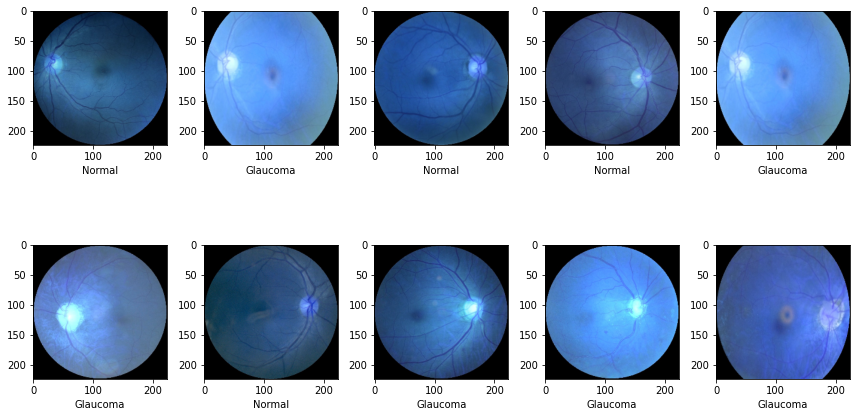

In [23]:
plt.figure(figsize=(12,7))
for i in range(10):
    sample = random.choice(range(len(dataset)))
    image = dataset[sample][0]
    category = dataset[sample][1]
    if category== 0:
        label = "Normal"
    else:
        label = "Glaucoma"
    plt.subplot(2,5,i+1)
    plt.imshow(image)
    plt.xlabel(label)
plt.tight_layout()

In [24]:
x = np.array([i[0] for i in dataset]).reshape(-1,image_size,image_size,3)
y = np.array([i[1] for i in dataset])

In [25]:
from sklearn.model_selection import train_test_split
x_train,x_test,y_train,y_test = train_test_split(x,y,test_size=0.2)

In [26]:
from tensorflow.keras.applications.vgg19 import VGG19
vgg = VGG19(weights="imagenet",include_top = False,input_shape=(image_size,image_size,3))

80150528/80134624 [==============================] - 2s 0us/step


In [27]:
for layer in vgg.layers:
    layer.trainable = False

In [28]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Flatten,Dense
model = Sequential()
model.add(vgg)
model.add(Flatten())
model.add(Dense(1,activation="sigmoid"))

In [29]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg19 (Functional)          (None, 7, 7, 512)         20024384  
                                                                 
 flatten (Flatten)           (None, 25088)             0         
                                                                 
 dense (Dense)               (None, 1)                 25089     
                                                                 
Total params: 20,049,473
Trainable params: 25,089
Non-trainable params: 20,024,384
_________________________________________________________________


In [30]:
model.compile(optimizer="adam",loss="binary_crossentropy",metrics=["accuracy"])

In [31]:
from tensorflow.keras.callbacks import ModelCheckpoint,EarlyStopping
checkpoint = ModelCheckpoint("vgg19.h5",monitor="val_acc",verbose=1,save_best_only=True,
                             save_weights_only=False,period=1)
earlystop = EarlyStopping(monitor="val_acc",patience=5,verbose=1)

In [32]:
history = model.fit(x_train,y_train,batch_size=32,epochs=15,validation_data=(x_test,y_test),
                    verbose=1,callbacks=[checkpoint,earlystop])

Epoch 1/15
28/28 [==============================] - 47s 986ms/step - loss: 2.2716 - accuracy: 0.6944 - val_loss: 1.9513 - val_accuracy: 0.7668
Epoch 2/15
28/28 [==============================] - 9s 339ms/step - loss: 0.4406 - accuracy: 0.8955 - val_loss: 1.4057 - val_accuracy: 0.8206
Epoch 3/15
28/28 [==============================] - 9s 341ms/step - loss: 0.0828 - accuracy: 0.9742 - val_loss: 1.2470 - val_accuracy: 0.8834
Epoch 4/15
28/28 [==============================] - 10s 343ms/step - loss: 0.0259 - accuracy: 0.9910 - val_loss: 1.2135 - val_accuracy: 0.8700
Epoch 5/15
28/28 [==============================] - 10s 342ms/step - loss: 0.0159 - accuracy: 0.9966 - val_loss: 1.1847 - val_accuracy: 0.8834
Epoch 6/15
28/28 [==============================] - 9s 341ms/step - loss: 0.0294 - accuracy: 0.9921 - val_loss: 1.0666 - val_accuracy: 0.8655
Epoch 7/15
28/28 [==============================] - 10s 342ms/step - loss: 0.1272 - accuracy: 0.9607 - val_loss: 1.3786 - val_accuracy: 0.8430
Ep

In [33]:
loss,accuracy = model.evaluate(x_test,y_test)
print("loss:",loss)
print("Accuracy:",accuracy)

7/7 [==============================] - 2s 287ms/step - loss: 1.4978 - accuracy: 0.8879
loss: 1.4977514743804932
Accuracy: 0.8878923654556274


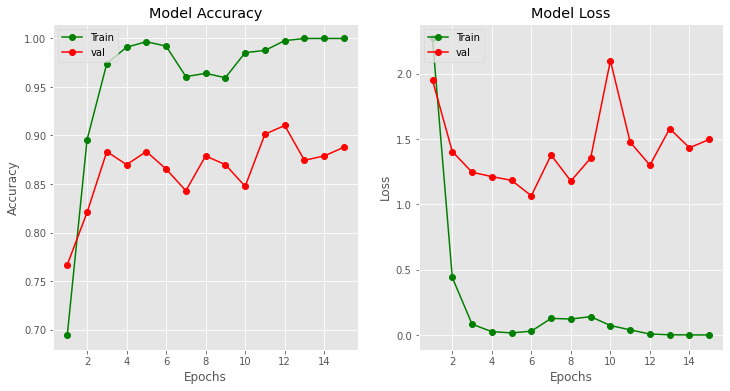

In [34]:
plt.style.use("ggplot")
fig = plt.figure(figsize=(12,6))
epochs = range(1,16)
plt.subplot(1,2,1)
plt.plot(epochs,history.history["accuracy"],"go-")
plt.plot(epochs,history.history["val_accuracy"],"ro-")
plt.title("Model Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(["Train","val"],loc = "upper left")

plt.subplot(1,2,2)
plt.plot(epochs,history.history["loss"],"go-")
plt.plot(epochs,history.history["val_loss"],"ro-")
plt.title("Model Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(["Train","val"],loc = "upper left")
plt.show()